# Visualizing Option Strategies

Options are an investment method where a contract is written to allow someone to buy or sell a number of shares of stock for a specified price, at any time before the contract expires.  "Call" options mean that the holder of the contract has the right to buy a set number of shares from the contract seller for the "strike" price - the price specified in the contract.  "Put" options give the holder the right to sell shares for the strike price.

Options can be used as a "hedge", or protection from the movement of a stock you own, or they can be used as an investment in themselves.  For a more in-depth explanation try [Investopedia].(https://www.investopedia.com/terms/o/option.asp)

To get the basic data for available stocks and their options, we'll be using the [yfinance](https://pypi.org/project/yfinance/) module for Python.  This module not only gives an excelent amount of information on the company itself, but we can get the important data for it's option chains as well.  Here we'll start by getting the current price of Apple (symbol AAPL).

In [42]:
import yfinance as yf
import json

symbol = "AAPL"

# Create the object representing the symbol of interest
equity = yf.Ticker(symbol)

current_price = equity.info['currentPrice']
print(f"Current price of {symbol} - ${current_price}")


Current price of AAPL - $155.11


## Pricing a Call Option 

For the sake of this tutorial, we're going to use a call option with an expiration a few days out.  This would be suitable for extremely short term investing.  

In order to price options, we need a couple of pieces of information from the current market conditions.  The strike price is the price that the option contract can be executed.  This means the price which your contract specifies that the shares of underlying stock will be sold at.  Implied volatility represents the rate that a stock will change in price randomly up or down before the contract expires. We use the term "implied" because the number is linked to trader's demand for the stock (which in turn can affect the price).

In [43]:
# Lets choose the options out a few days
expiration_date = equity.options[1]
print("Expiration Date: ", expiration_date)

# get option chain for specific expiration
opt = equity.option_chain(expiration_date)

# Choosing a strike price appropriate for our strategy
strike_price = 160

# Get the available data for the option contract with our chosen strike price
option_data_at_strike = opt.calls.loc[opt.calls['strike'] == strike_price]
implied_volatility = option_data_at_strike['impliedVolatility'].values[0]
print(f"Option Implied Volatility: {implied_volatility}")

Expiration Date:  2021-09-17
Option Implied Volatility: 0.256843369140625


## Visualizing Performance

We want to visualize how the value of our investment might change based on the changes to the share price.  This gives us an opportunity to judge how our strategy will perform if the market moves the way we expect.  To do this, we'll first get the number of days remaining between now and the expiration date of the option contract. 

In [44]:
from datetime import date

current_date_object = date.today()
expiration_date_object = date.fromisoformat(expiration_date)

# We need the number of days until expiration for our plots
days_to_expire = (expiration_date_object - current_date_object).days

Since we don't really know which direction the share price will move, we'll account for a price swing of $20 up or down by expiration.

In [45]:
import numpy as np
np.set_printoptions(suppress=True)

# Create an array of possible share prices starting $20 below the current
# price and ending $20 above the current price, at $1 intervals.
share_prices = np.arange(current_price-20, current_price+20, 1)

Now for the heart of the program.  We need a function to actually create the matrix of possible share prices each day, and the corresponding value of the position.  [Mibian](https://pypi.org/project/mibian/) is a library for pricing European and American stock options.  By using the share price, strike price of the option, number of days until contract expiration, and the implied volatility, we can use the Black-Scholes pricing model to predict the price of an option at some point in the future.

In [46]:
import mibian

def create_value_matrix(prices, 
                        number_of_days, 
                        strike, 
                        implied_volatility):
    # Create an empty array to hold the estimated option values
    output_array = np.zeros((len(prices), number_of_days))

    # For each possible share price...
    for i, p in enumerate(prices):
        # ...and each day from now to expiration
        for d in range(number_of_days):
            # Get the Black-Scholes data for the contract assuming the 
            # given price and days until expiration
            bsData = mibian.BS([p, strike, 0, number_of_days - d], 
                               volatility= implied_volatility*100)
            
            # For the sake of this tutorial, we're doing strategies with calls.
            # Puts are similar
            price = bsData.callPrice
            output_array[i,d] = round(price, 2)
            
    return output_array
        
price_matrix = create_value_matrix(share_prices, 
                                   days_to_expire, 
                                   strike_price, 
                                   implied_volatility)

# Keep in mind, the origin of the points on the matrix is in the upper left,
# this means it's upside down from what we're expecting, with higher share
# prices increasing from top to bottom and days counting from left to right.
print(price_matrix)

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.03  0.02  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.04  0.03  0.02  0.01  0.    0.    0.    0.    0.  ]
 [ 0.07  0.05  0.03  0.02  0.01  0.    0.    0.    0.  ]
 [ 0.1   0.07  0.05  0.03  0.01  0.01  0.    0.    0.  ]
 [ 0.15  0.11  0.08  0.05  0.03  0.01  0.    0.    0.  ]
 [ 0.22  0.17  0.13  0.09  0.05  0.03  0.01  0.    0.  ]
 [ 0.32  0.25  0.19  0.14  0.09

Now we can create a matrix of the value of an option across different underlying share prices and days remaining to expiration.  The numbers are helpful, but it would be nice to add some color to really get a feel for what happens as the value of the stock changes.

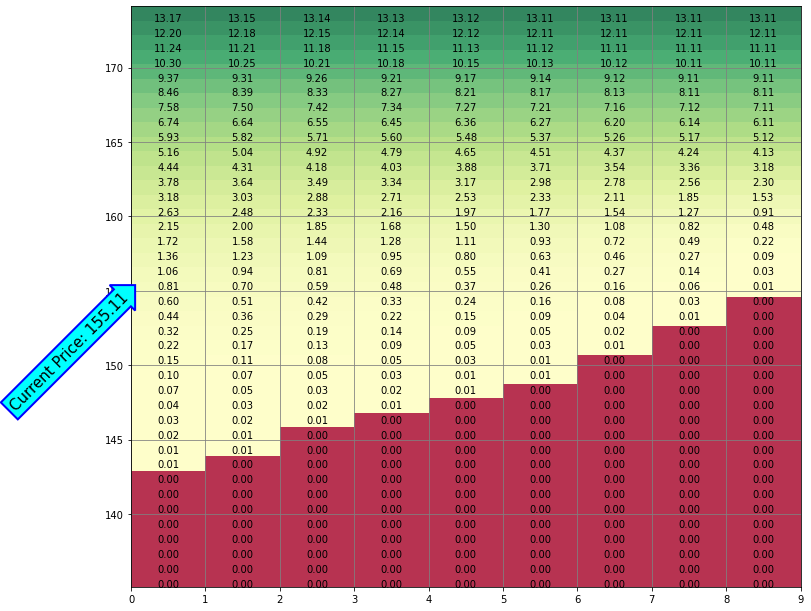

In [47]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patheffects as PathEffects

# We want to take an arbitrary price matrix and display it nicely
def display_value_matrix(matrix, 
                         share_prices, 
                         days_to_expire, 
                         underlying_price):
    fig, ax = plt.subplots(figsize=(12,12))

    for x in range(days_to_expire):
        for i in range(len(share_prices)-1):
            y = share_prices[i]
            txt = ax.text(x+0.5,y , "{:.2f}".format(matrix[i,x]), 
                          ha='center', color='k')

    divnorm=colors.TwoSlopeNorm(vmin=np.min(matrix), 
                                vcenter=0.0001, 
                                vmax=np.max(matrix))
            
    ax.imshow(matrix, origin="lower", cmap="RdYlGn", alpha=0.8,
              extent = [0 , days_to_expire, 
                        share_prices[0], share_prices[-1]],
              norm=divnorm)
    
    ax.text(0, underlying_price, 
            "Current Price: {:.2f}".format(underlying_price), 
            ha="right", va="top", rotation=45, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2))

    ax.grid(which="both", c="grey", linewidth=0.8)

    ax.set_aspect(0.2)
    plt.show()
    
display_value_matrix(price_matrix, 
                     share_prices, 
                     days_to_expire, 
                     current_price)

## Interpreting the Graph

At the current share price of $155.11, we can buy a call with a strike of $160 for roughly $2.63 per share.  If tomorrow the AAPL share price were to jump to $165, our option would suddenly be worth $5.93!

On the other hand, if the price of AAPL were to stay near it's current value, then at expiration 10 days from now, the price would drop to zero.

## Short (Naked) Calls

What if we were to sell a call option instead of buying?  We would get the price of the option as cash immediately, but we run a risk that if the share price increases, our contract could be excercised and we would owe the 100 shares.  The chart below shows that the profits of such a trade are limited, but the potential losses are infinite.  Generally, naked calls are not a good approach to investing.

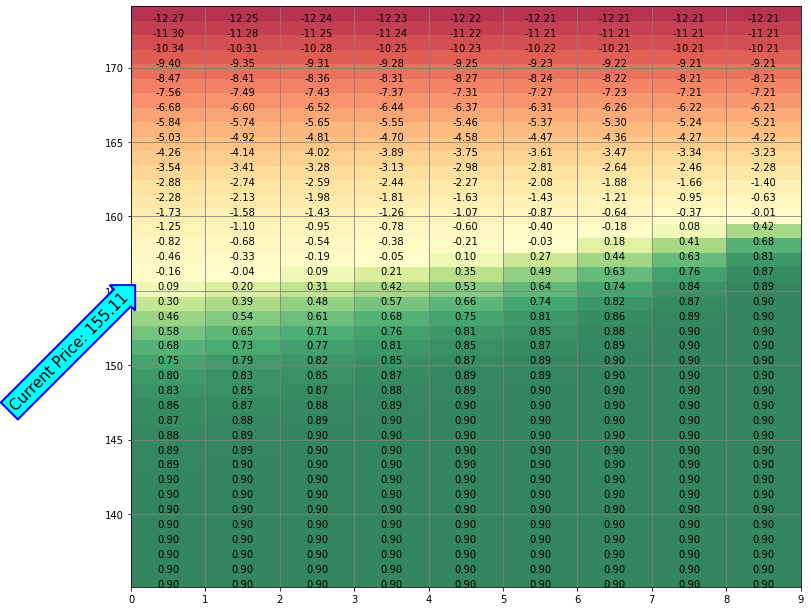

In [48]:
# Short Call

# Get the current price of the option we want to sell
current_option_price = option_data_at_strike['lastPrice'].values[0]

# Now, the values of our matrix will be the money we get from selling 
# the option, minus the current value of the option.
# For example, if we were to sell the option for $1, then immediately 
# buy it back to close the position, it would effectively have no value.
# +$1 selling, -$1 buying to close = $1-$1 = $0
short_values = current_option_price - price_matrix

display_value_matrix(short_values, share_prices, days_to_expire, current_price)

## Basic Strategy - Covered Calls

Let's say we own 100 shares of AAPL stock and we're concerned that the price may fall in the near future.  We can use options to give us some quick income to help offset the losses we're expecting.  By selling a call option backed by our shares of stock, we are selling a "Covered Call", a contract that says we will sell our 100 shares to the holder of the contract at the predetermined (strike) price.  By selling a contract with a strike above the current price could be forced to sell our shares at the increased price, but since we expect the price to go down, we expect to keep the money from selling the contract and keep our shares as well.

It's important to note that we can get ourselves out of the contract at any time buy performing a "buy to close" trade.  We buy a contract identical to the one we sold, but at the current price.  This offsets the option we sold and gets us out of the obligation.

## Strategies with Multiple Options

There are many common strategies that involve multiple options in a single position.  An example is a "Call Credit Spread" also known as a "Bear Call Spread".  This is a bearish strategy, where you are expecting the underlying stock to go down.  It consists of buying a call option with a strike price above the current share price (called "Out of the Money") and at the same time selling a call option with a strike below the current share price ("In the Money").  The difference in price between the two options is the maximum profit you can get from the trade, assuming the stock price does go down at expiration.

Short Price:  6.02
Long Price:  0.9


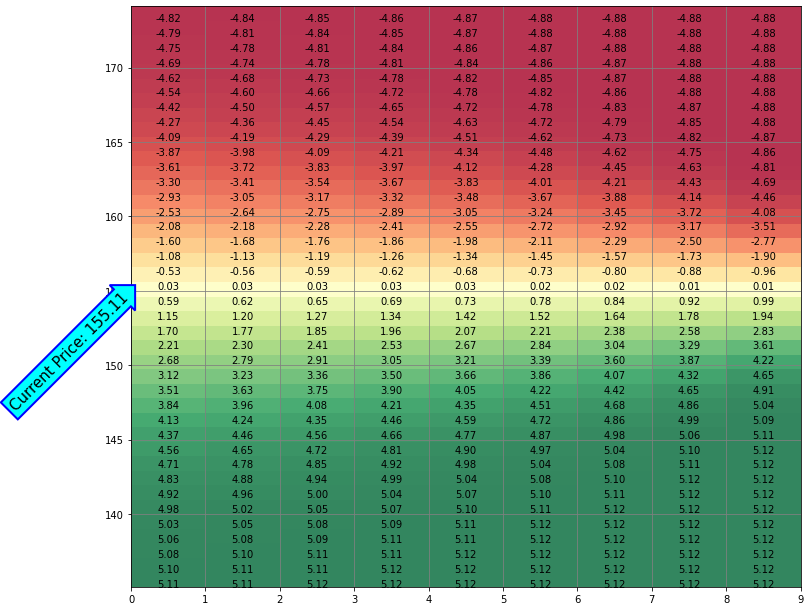

In [52]:
# More complicated strategies - Call Credit Spread

# Short (sell) position
short_strike_price = 150
short_option_data_at_strike = opt.calls.loc[opt.calls['strike'] == short_strike_price]
short_implied_volatility = short_option_data_at_strike['impliedVolatility'].values[0]
short_option_price = short_option_data_at_strike['lastPrice'].values[0]
short_call_matrix = create_value_matrix(share_prices, 
                                        days_to_expire, 
                                        short_strike_price, 
                                        short_implied_volatility)

print("Short Price: ", short_option_price)

# Long (buy) position
long_strike_price = 160
long_option_data_at_strike = opt.calls.loc[opt.calls['strike'] == long_strike_price]
long_implied_volatility = long_option_data_at_strike['impliedVolatility'].values[0]
long_option_price = long_option_data_at_strike['lastPrice'].values[0]
long_call_matrix = create_value_matrix(share_prices, 
                                       days_to_expire, 
                                       long_strike_price, 
                                       long_implied_volatility)

print("Long Price: ", long_option_price)

# The entry cost is the amount we get when we first buy and sell our options
entry_cost = short_option_price - long_option_price

# The matrix for this position is the entry cost minus the amount 
# it would take to close the positions.
call_spread_matrix = entry_cost - short_call_matrix + long_call_matrix

display_value_matrix(call_spread_matrix, 
                     share_prices, 
                     days_to_expire, 
                     current_price)

## Interpreting the Credit Spread Plot

Looking at the above plot, we can see a few things.  First, we see that Credit Spreads have a limit to their profits or losses.  In fact, if the share price falls quickly like we hope, we may be able to cash out for full profit several days early.